n =  [   0    1    2 ... 2045 2046 2047]


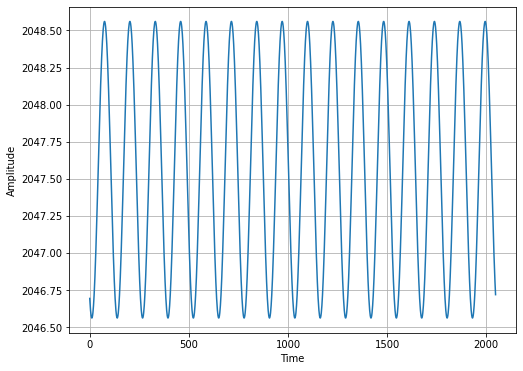

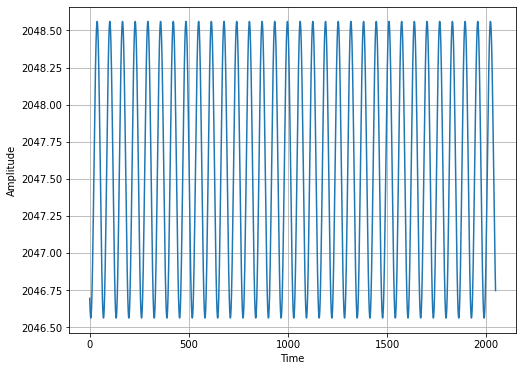

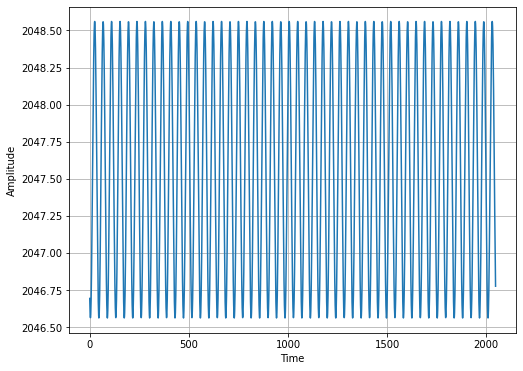

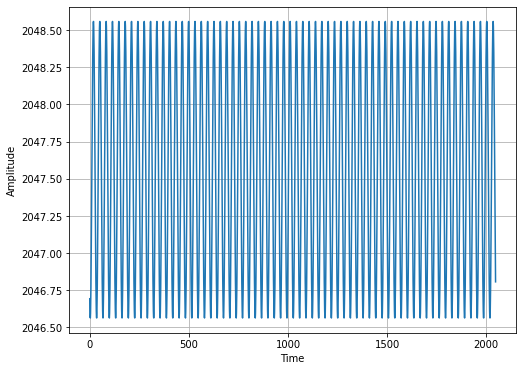

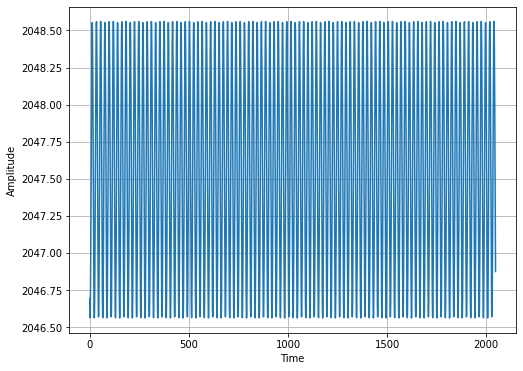

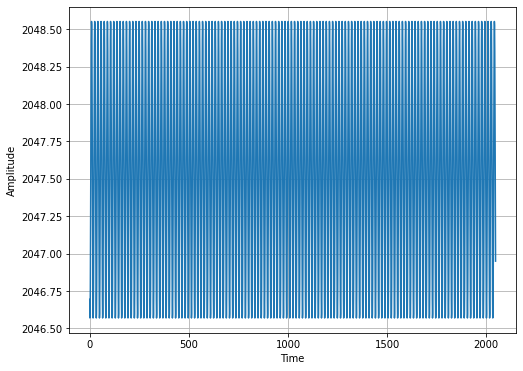

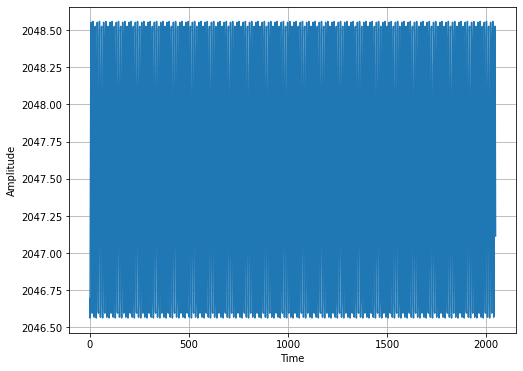

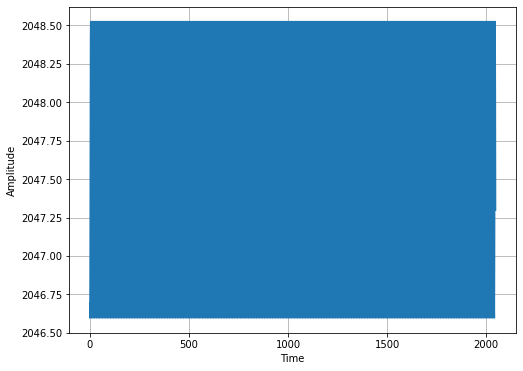

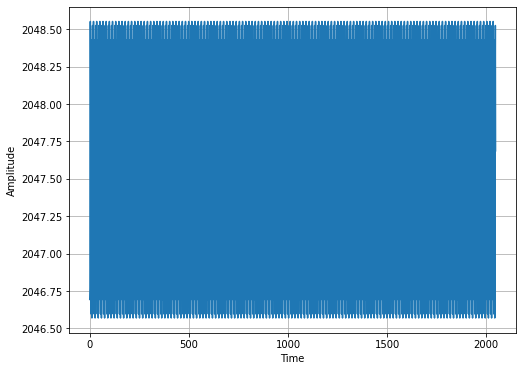

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import random

fs = 32000 #sampling rate
Ts = 1/fs #time duration
#t=0.1 
freqList = [250,500, 750 ,1000, 1500, 2000, 3000, 4000, 6000] 
#n = np.linspace(0,1,2048) #no of samples
n = np.arange(0,2048,1) #no of samples
print("n = ",n)
noise = np.random.normal(2048) 
phase = 2* np.pi *np.random.random(1)
for freq in freqList:
    y = np.sin(2* np.pi * freq *n * Ts + phase) + noise
    plt.figure(figsize = (8, 6))
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.plot(n,y)
    plt.savefig('Sinewave.png'.format(freq))
    plt.show()

In [43]:
import pandas as pd
import seaborn as sns
from math import sqrt
import math
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense,Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout
#from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import LSTM, MaxPooling1D, Conv1D, Flatten, LeakyReLU, Activation, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import datetime
import matplotlib.pyplot as plt
from pandas import Series
from numpy.random import randn
import os
import random as rn
import numpy as np
import time
import tensorflow as tf

In [23]:
#using the MachineLearningMastery formula for splitting up the dataset to predictors and target
#since The input to an LSTM network is a 3D array:
#Converted to :(samples, timesteps, features)
#samples — total number of sequences constructed for training.
#timesteps — the length of the samples.
#features — number of features used.data that is in a 2D format convert into a 3D array

def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [24]:
# Number of lags (hours back) to use for models
lag = 256
# Steps in future to forecast 
n_ahead = 64
# ration of observations in training from total series
train_share = 0.7
val_share = 0.8
# training epochs
epochs = 100
# Batch size , which is the number of samples of lags
batch_size = 1
# Learning rate
lr = 0.001

In [25]:
data = y.reshape(-1,1)

In [26]:
data.shape

(2048, 1)

In [27]:
#Scaling data between 0 and 1
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

#scaler.fit(data)
#ts_scaled = scaler.transform(data)

In [28]:
# Creating the X and Y for training
X, Y = create_X_Y(data, lag=lag, n_ahead=n_ahead)

In [29]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * train_share)], Y[0:int(X.shape[0] * train_share)]
Xtest, Ytest = X[int(X.shape[0] * val_share):], Y[int(X.shape[0] * val_share):]
Xval, Yval = X[int(X.shape[0] * train_share):int(X.shape[0] * val_share)], Y[int(X.shape[0] * train_share):int(X.shape[0] * val_share)]

In [30]:
Xtrain.shape

(1209, 256, 1)

In [31]:
Xtest.shape

(346, 256, 1)

In [32]:
Xval.shape

(173, 256, 1)

In [33]:
#Neural Network Model configuration
model = Sequential()

model.add(LSTM(32, activation='relu', input_shape=(Xtrain.shape[1], Xtrain.shape[2]), return_sequences=True))
#model.add(CuDNNLSTM(32, input_shape=(Xtrain.shape[1], Xtrain.shape[2]), return_sequences=True))
model.add(LSTM(16, activation='relu', return_sequences=False))
#model.add(CuDNNLSTM(16, return_sequences=False))
model.add(Dense(64))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0.001)
model.summary()

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics='mae')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256, 32)           4352      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1088      
Total params: 8,576
Trainable params: 8,576
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
38/38 [==============================] - 12s 319ms/step - loss: 0.7894 - mae: 0.7894 - val_loss: 0.3738 - val_mae: 0.3738
Epoch 2/100
38/38 [==============================] - 12s 309ms/step - loss: 0.3869 - mae: 0.3869 - val_loss: 0.3529 - val_mae: 0.3529
Epoch 3/100
38/38 [==============================] - 10s 267ms/step - loss: 0.3405 - mae: 0.3405 - val_loss: 0.2988 - val_mae: 0.2988
Epoch 4/100
38/38 [==============================] - 10s 270ms/step - loss: 0.2867 - mae: 0.2867 - val_loss: 0.2474 - val_mae: 0.2474
Epoch 5/100
38/38 [==============================] - 11s 277ms/step - loss: 0.2415 - mae: 0.2415 - val_loss: 0.2138 - val_mae: 0.2138
Epoch 6/100
38/38 [==============================] - 11s 281ms/step - loss: 0.2190 - mae: 0.2190 - val_loss: 0.2027 - val_mae: 0.2027
Epoch 7/100
38/38 [==============================] - 10s 274ms/step - loss: 0.2118 - mae: 0.2118 - val_loss: 0.1989 - val_mae: 0.1989
Epoch 8/100
38/38 [==============================] - 11s 283ms

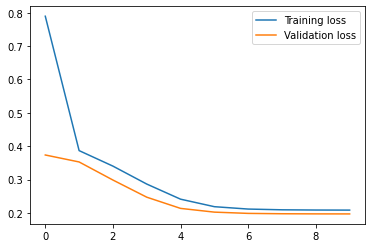

In [34]:
#Train model on train data
history = model.fit(Xtrain, Ytrain,epochs=epochs, validation_data=(Xval, Yval), shuffle=False, callbacks=[early_stopping])
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()

In [40]:
#yhat = [x[0] for x in model.predict(Xtest)]
#y = [y[0] for y in Ytest]

In [35]:
yhat = model.predict(Xtest)
yhat.shape

(346, 64)

In [36]:
pred_n_ahead = pd.DataFrame(yhat[0])
actual_n_ahead = pd.DataFrame(Ytest[0])

In [37]:
Ytest.shape

(346, 64)

<function matplotlib.pyplot.show(close=None, block=None)>

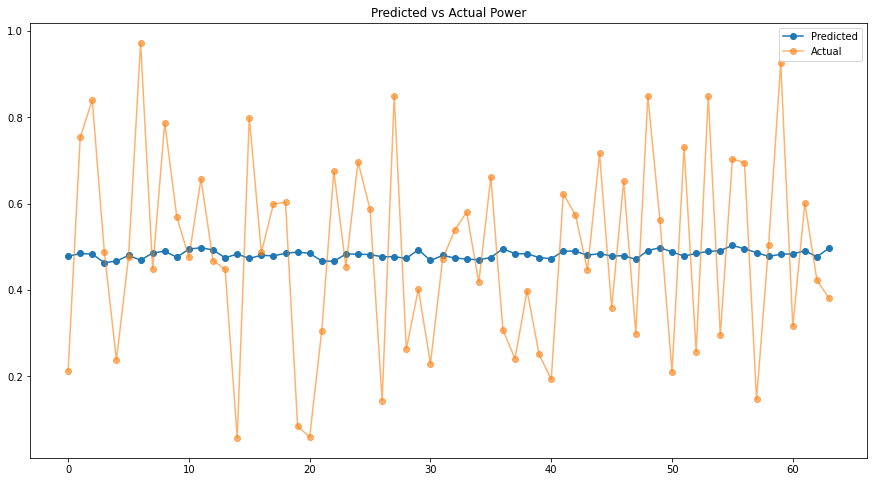

In [38]:
#plot n_steps ahead for predicted and actual data
plt.figure(figsize=(15, 8))
plt.plot(pred_n_ahead, color='C0', marker='o', label='Predicted')
plt.plot(actual_n_ahead, color='C1', marker='o', label='Actual', alpha=0.6)
plt.title('Predicted vs Actual Power')
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.legend()
plt.show

In [39]:
#evaluation metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape':mape, 'me':me, 'mae': mae,  'rmse':rmse, 
            'corr':corr})

forecast_accuracy(yhat,Ytest)

C:\Users\Sahana\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


{'mape': inf,
 'me': 0.0025849080119303134,
 'mae': 0.18818026720584063,
 'rmse': 0.22707638642441388,
 'corr': 0.9923939201628557}